# Neutralizations for DMS data validation

In [1]:
import os
import warnings

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from plotnine import *

import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE

import yaml
plt.rcParams['svg.fonttype'] = 'none'
print(f"Using `neutcurve` version {neutcurve.__version__}")

Using `neutcurve` version 2.1.0


In [2]:
warnings.simplefilter('ignore')

Read config file.

In [4]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

In [5]:
resultsdir=config['resultsdir']
os.makedirs(resultsdir, exist_ok=True)

## Read in data

In [6]:
frac_infect = pd.read_csv(config['RBD_depletion_neuts'], index_col=0)

## Fit Hill curve to data using [`neutcurve`](https://jbloomlab.github.io/neutcurve/)

In [7]:
fits = neutcurve.CurveFits(frac_infect,  fixtop= True)

In [8]:
fitparams = (
    fits.fitParams(ics=[50, 90])
    .assign(NT50=lambda x: 1/x['ic50'])
    )

# couldn't get lambda / conditional statement to work with assign, so try it here:
fitparams['ic50_is_bound'] = fitparams['ic50_bound'].apply(lambda x: True if x!='interpolated' else False)


In [9]:
fitparams.to_csv('results/depletion_neuts.csv', index=False)


In [10]:
color_list = ['#808080', '#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#000000', '#CC79A7']

## Plot neut curves

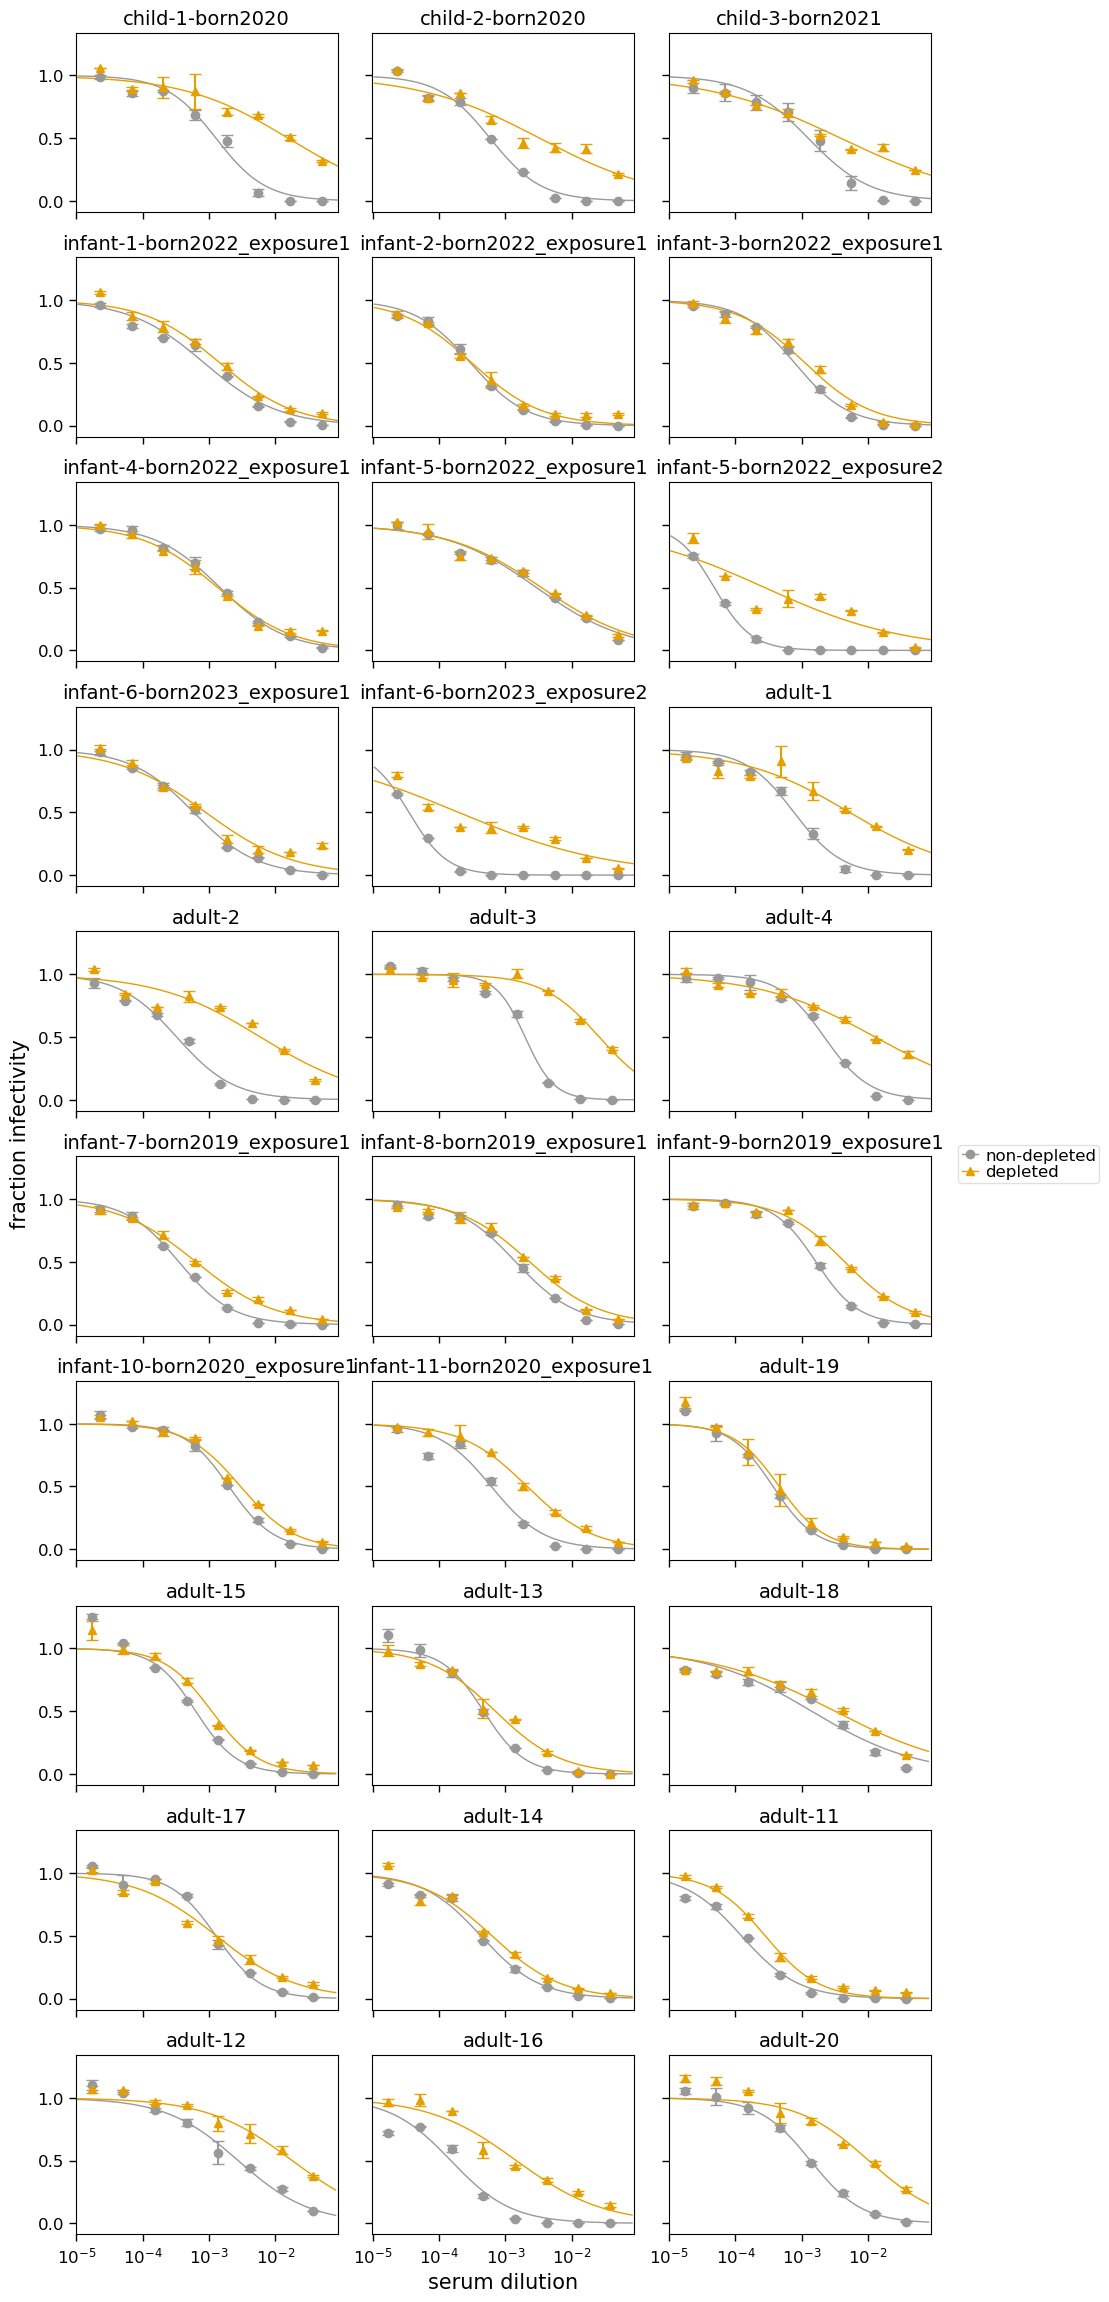

In [11]:
fig, axes = fits.plotSera(xlabel='serum dilution',
                          ncol=3
                         )
plotfile_svg = 'depletion_neuts.svg'
plotfile_png = 'depletion_neuts.png'
fig.savefig(f'{resultsdir}/{plotfile_svg}', bbox_inches='tight')
fig.savefig(f'{resultsdir}/{plotfile_png}', bbox_inches='tight')

In [12]:
# Mapping for group classification
group_mapping = {
    'child': [
        'child-1-born2020', 'child-2-born2020',
        'child-3-born2021', 'child-4-born2021'
    ],
    'XBB-infant-1': [
        'infant-1-born2022_exposure1', 'infant-2-born2022_exposure1',
        'infant-3-born2022_exposure1', 'infant-4-born2022_exposure1',
        'infant-5-born2022_exposure1', 'infant-6-born2023_exposure1'
    ],
    'XBB-infant-2': [
        'infant-5-born2022_exposure2', 'infant-6-born2023_exposure2'
    ],
    'adult': [
        'adult-1', 'adult-2', 'adult-3', 'adult-4'
    ],
    'Wu1-infant-1': [
        'infant-7-born2019_exposure1', 'infant-8-born2019_exposure1',
        'infant-9-born2019_exposure1', 'infant-10-born2020_exposure1',
        'infant-11-born2020_exposure1'
    ],
    'Wu1-adult': [
        'adult-11', 'adult-12','adult-13', 'adult-14',
        'adult-15','adult-16', 'adult-17','adult-18',
        'adult-19','adult-20'
    ]
}

# Assign group based on serum value
def assign_group(serum_value):
    for group, keywords in group_mapping.items():
        if serum_value in keywords:
            return group
    return None

# Apply the function
fitparams['group'] = fitparams['serum'].apply(assign_group)


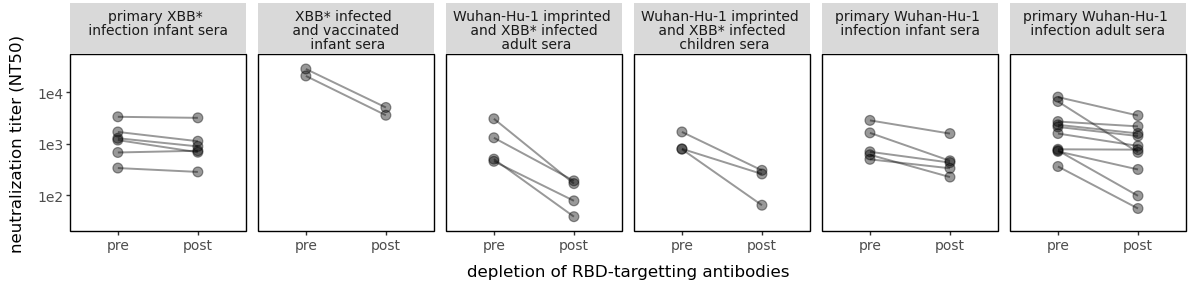

In [16]:
fitparams['group_label'] = fitparams['group'].map({
    'adult': 'Wuhan-Hu-1 imprinted \n and XBB* infected \n adult sera',    
    'child': 'Wuhan-Hu-1 imprinted \n and XBB* infected \n children sera',
    'XBB-infant-1': 'primary XBB* \n infection infant sera \n',
    'XBB-infant-2': 'XBB* infected \n and vaccinated \n infant sera',
    'Wu1-infant-1': 'primary Wuhan-Hu-1 \n infection infant sera \n',
    'Wu1-adult': 'primary Wuhan-Hu-1 \n infection adult sera \n'
})

# Set the categorical order for group_label
group_label_order = [
    'primary XBB* \n infection infant sera \n',
    'XBB* infected \n and vaccinated \n infant sera',
    'Wuhan-Hu-1 imprinted \n and XBB* infected \n adult sera',
    'Wuhan-Hu-1 imprinted \n and XBB* infected \n children sera', 
    'primary Wuhan-Hu-1 \n infection infant sera \n',
    'primary Wuhan-Hu-1 \n infection adult sera \n'
    
]
fitparams['group_label'] = pd.Categorical(
    fitparams['group_label'], categories=group_label_order, ordered=True
)

fitparams['depletion'] = fitparams['virus'].map({
    'non-depleted': 'pre',    
    'depleted': 'post'
})

NT50_faceted = (ggplot(fitparams, aes(x='depletion', y='NT50', group='serum')) +
              geom_point(size=3.5, alpha = 0.4) +
              geom_line(size=.8, alpha = 0.4) +
              theme(
                   figure_size=(12,3),
                   axis_text=element_text(size=10),
                   axis_text_x=element_text(size=10),
                   legend_text=element_text(size=10),
                   axis_title_x=element_text(size=12),
                   axis_title_y=element_text(size=12),
                   strip_text=element_text(size=10),
                   panel_background=element_rect(fill='white'),
                   plot_background=element_rect(fill='white'),
                  panel_border=element_line(size=1)
                  ) +
              scale_y_log10(expand=(0.03, .2)) +
              ylab('neutralization titer (NT50)') +
              xlab('depletion of RBD-targetting antibodies') +
              scale_color_manual(values=CBPALETTE[1:])+
              scale_x_discrete(limits=['pre', 'post']) +
              facet_wrap('~group_label', ncol=6)
               )


NT50_faceted.save("results/NT50s_depleted.svg", format="svg")
NT50_faceted.save("results/NT50s_depleted.png", format="png", dpi=300)
NT50_faceted.draw()

In [17]:
#calculate % RBD-targetting antibodies
df_pre = fitparams.loc[fitparams['virus'] == 'non-depleted']
df_post = fitparams.loc[fitparams['virus'] == 'depleted']
df_merge = pd.merge(df_pre, df_post, on="serum")
df_merge['percent_RBD'] = (df_merge['NT50_x']-df_merge['NT50_y'])/df_merge['NT50_x']*100
df_merge['percent_RBD'] = df_merge['percent_RBD'].astype(int)
fitparams = pd.merge(fitparams,df_merge[['serum','percent_RBD']],on='serum', how='left')
fitparams['percent_RBD_str'] = fitparams['percent_RBD'].astype(str) +'%'

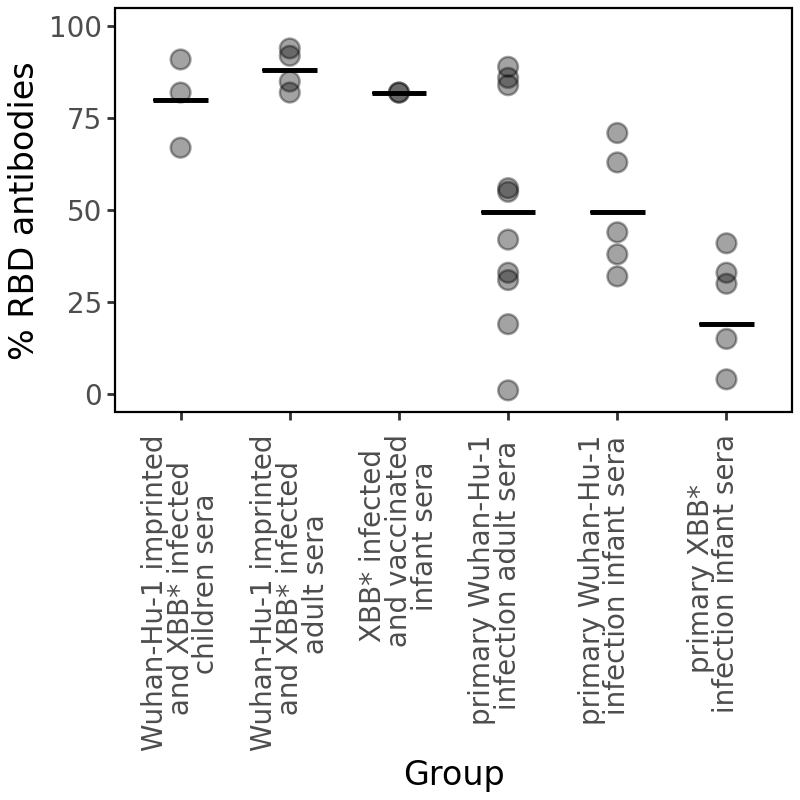

In [18]:
group_label_order = [    
    'Wuhan-Hu-1 imprinted \n and XBB* infected \n children sera',
    'Wuhan-Hu-1 imprinted \n and XBB* infected \n adult sera',
    'XBB* infected \n and vaccinated \n infant sera',
    'primary Wuhan-Hu-1 \n infection adult sera \n',
    'primary Wuhan-Hu-1 \n infection infant sera \n',
    'primary XBB* \n infection infant sera \n',
]
fitparams['group_label'] = pd.Categorical(
    fitparams['group_label'], categories=group_label_order, ordered=True
)

# Calculate the mean percent_RBD for each group_label
mean_values = fitparams.groupby('group_label')['percent_RBD'].mean().reset_index()

# Merge mean values back into fitparams to avoid alignment issues
fitparams = fitparams.merge(mean_values, on='group_label', suffixes=('', '_mean'))

RBD_percent = (ggplot(fitparams, aes(x='group_label', y='percent_RBD')) +
               geom_jitter(position=position_dodge(width=0.5), size=3.5, alpha=0.2) +
               theme(
                   figure_size=(4, 4),
                   axis_text=element_text(size=10),
                   axis_text_x=element_text(size=10, angle=90),
                   legend_text=element_text(size=10),
                   axis_title_x=element_text(size=12),
                   axis_title_y=element_text(size=12),
                   strip_text=element_text(size=10),
                   panel_background=element_rect(fill='white'),
                   plot_background=element_rect(fill='white'),
                   panel_border=element_line(size=.8)
                  ) +
               geom_crossbar(data=(mean_values),
                   mapping=aes(x='group_label', ymin='percent_RBD', ymax='percent_RBD'),
                   position=position_dodge(width=0.5),)+
               ylim(0, 100) +
               ylab('% RBD antibodies') +
               xlab('Group') +
               scale_color_manual(values=CBPALETTE[1:])
              )

# Save the plot
RBD_percent.save("results/RBDpercent.svg", format="svg")
RBD_percent.save("results/RBDpercent.png", format="png", dpi=300)

RBD_percent

## Compare to Greaney 2021

In [19]:
Greaney_df = pd.read_csv(config['Greaney_2021'])

In [20]:
# Melting the DataFrame
melted_df = pd.melt(
    Greaney_df,
    id_vars=['sample'],
    value_vars=['NT50_D614', 'NT50_post'],
    var_name='depletion',
    value_name='NT50'
)

In [21]:
melted_df['depletion'] = melted_df['depletion'].replace({
    'NT50_D614': 'pre',
    'NT50_post': 'post'
})

In [22]:
melted_df['group_label'] = 'primary Wuhan-1 \n exposed adults \n (high ACE2)'

In [23]:
infants = fitparams.loc[
    fitparams['group_label'].isin([
        'primary XBB* \n infection infant sera \n',
        'primary Wuhan-Hu-1 \n infection infant sera \n',
        'primary Wuhan-Hu-1 \n infection adult sera \n'
    ])
]
infants['sample'] = infants['serum']

In [24]:
df = pd.concat([infants, melted_df],ignore_index = True)

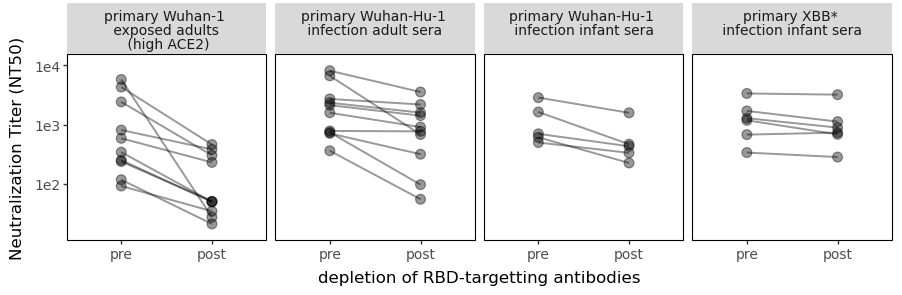

In [25]:
AG_BD_compare = (ggplot(df, aes(x='depletion', y='NT50', group='sample')) +
              geom_point(size=3.5, alpha = 0.4) +
              geom_line(size=.8, alpha = 0.4) +
              theme(
                   figure_size=(9,3),
                   axis_text=element_text(size=10),
                   axis_text_x=element_text(size=10),
                   legend_text=element_text(size=10),
                   axis_title_x=element_text(size=12),
                   axis_title_y=element_text(size=12),
                   strip_text=element_text(size=10),
                   panel_background=element_rect(fill='white'),
                   plot_background=element_rect(fill='white'),
                  panel_border=element_line( size=.8)
                  ) +
              scale_y_log10(expand=(0.03, .2)) +
              ylab('Neutralization Titer (NT50)') +
              xlab('depletion of RBD-targetting antibodies') +
              scale_color_manual(values=CBPALETTE[1:])+
              scale_x_discrete(limits=['pre', 'post']) +
              facet_wrap('~group_label', ncol=4)
               )


AG_BD_compare.save("results/NT50s_adult_wu1_infant_XBB.svg", format="svg")
AG_BD_compare.save("results/NT50s_adult_wu1_infant_XBB.png", format="png", dpi=300)
AG_BD_compare.draw()